In [1]:
!pip install h2o

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.0/266.0 MB 1.9 MB/s eta 0:00:00


In [33]:
import sys
import os

# file is run from the parent directory py model/baseline.py
sys.path.append('/content/drive/MyDrive/stroke-analysis')


from features.transformation import assemble_feature_set
import pandas as pd
import h2o; h2o.init()
from h2o.automl import H2OAutoML
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators import (
    H2OGradientBoostingEstimator,
    H2OXGBoostEstimator,
    H2ORandomForestEstimator,
)
from rich.traceback import install; install()
from sklearn.model_selection import train_test_split

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,1 hour 11 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.9
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_unknownUser_eyapab
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.095 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [34]:
def prepare_data(raw_df):
    df_featurized = assemble_feature_set(raw_df)
    train_df, temp_df = train_test_split(
        df_featurized, stratify=df_featurized["stroke"], test_size=0.3, random_state=42
    )
    valid_df, test_df = train_test_split(
        temp_df, stratify=temp_df["stroke"], test_size=0.5, random_state=42
    )
    counts = train_df["stroke"].value_counts().to_dict()
    total = sum(counts.values())
    n_classes = len(counts)
    class_weights = {cls: total / (n_classes * count) for cls, count in counts.items()}
    for df in [train_df, valid_df, test_df]:
        df["weights"] = df["stroke"].map(class_weights)
    return train_df, valid_df, test_df, class_weights

def train_models(train_df, valid_df, test_df):
    h2o.init()
    h2o_train = h2o.H2OFrame(train_df)
    h2o_valid = h2o.H2OFrame(valid_df)
    h2o_test  = h2o.H2OFrame(test_df)
    for f in [h2o_train, h2o_valid, h2o_test]:
        f['stroke'] = f['stroke'].asfactor()

    y = "stroke"
    x = [c for c in h2o_train.columns if c not in [y, "weights"]]
    aml = H2OAutoML(
        max_models=50,
        seed=1984,
        nfolds=0, # disable internal cv
        stopping_metric="AUCPR",
        sort_metric="AUCPR",
        exclude_algos=["GLM", "StackedEnsemble", "DeepLearning"],
        balance_classes=False,
        max_runtime_secs=300,
    )
    aml.train(x=x, y=y, training_frame=h2o_train, validation_frame=h2o_valid, weights_column="weights")
    leader = aml.leader
    test_perf = leader.model_performance(h2o_test)
    print("Test AUCPR:", test_perf.aucpr())
    return aml, h2o_train, h2o_valid, h2o_test

def fine_tune_best_model(aml, h2o_train, h2o_valid, h2o_test, metric="AUCPR"):
    best_model = aml.leader
    algo = best_model.algo

    exclude_keys = {
            "model_id", "training_frame", "validation_frame", "nfolds",
            "response_column", "ignored_columns", "weights_column",
            "stopping_metric", "stopping_rounds", "stopping_tolerance",
            "max_runtime_secs", "seed", "categorical_encoding",
            "quiet_mode", "backend", "score_each_iteration"
        }

    params = {k: v["actual"] for k, v in best_model.params.items() if v["actual"] is not None and k not in exclude_keys}

    if algo == "gbm":
        base_est = H2OGradientBoostingEstimator()
    elif algo == "xgboost":
        base_est = H2OXGBoostEstimator()
    elif algo == "drf":
        base_est = H2ORandomForestEstimator()
    else:
        raise ValueError(f"Unsupported algorithm: {algo}")


    def around(value, lower=0.8, upper=1.2, minv=None, maxv=None):
        """Utility to generate small neighborhood around numeric parameter."""
        if not isinstance(value, (int, float)):
            return [value]
        lo = max(minv, value * lower) if minv is not None else value * lower
        hi = min(maxv, value * upper) if maxv is not None else value * upper
        return sorted(set([value, round(lo, 6), round(hi, 6)]))

    # construct hyperparameter ranges centered on the model’s own params
    hyper_params = {}

    if "ntrees" in params:
        hyper_params["ntrees"] = [
            max(50, int(params["ntrees"] * 0.8)),
            int(params["ntrees"]),
            int(params["ntrees"] * 1.2)
        ]

    if "max_depth" in params:
        hyper_params["max_depth"] = list(
            set([params["max_depth"] - 1, params["max_depth"], params["max_depth"] + 1])
        )

    if "learn_rate" in params:
        hyper_params["learn_rate"] = around(params["learn_rate"], 0.5, 1.5, 0.001, 0.3)

    if "min_rows" in params:
        hyper_params["min_rows"] = around(params["min_rows"], 0.5, 1.5, 1, None)

    if "min_split_improvement" in params:
        hyper_params["min_split_improvement"] = around(params["min_split_improvement"], 0.5, 1.5, 1e-7, 1e-2)

    # Algorithm-specific parts
    if algo == "xgboost":
        if "reg_lambda" in params:
            hyper_params["reg_lambda"] = around(params["reg_lambda"], 0.5, 2.0, 0, 10)
        if "reg_alpha" in params:
            hyper_params["reg_alpha"] = around(params["reg_alpha"], 0.5, 2.0, 0, 10)
        if "min_child_weight" in params:
            hyper_params["min_child_weight"] = around(params["min_child_weight"], 0.5, 1.5, 1, 20)
        if "subsample" in params:
            hyper_params["subsample"] = around(params["subsample"], 0.9, 1.1, 0.6, 1.0)
        if "colsample_bytree" in params:
            hyper_params["colsample_bytree"] = around(params["colsample_bytree"], 0.9, 1.1, 0.6, 1.0)

    elif algo == "gbm":
        if "sample_rate" in params:
            hyper_params["sample_rate"] = around(params["sample_rate"], 0.9, 1.1, 0.6, 1.0)
        if "col_sample_rate" in params:
            hyper_params["col_sample_rate"] = around(params["col_sample_rate"], 0.9, 1.1, 0.6, 1.0)

    search_criteria = {
        "strategy": "RandomDiscrete",
        "max_models": 20,
        "seed": 42,
        "stopping_metric": "AUCPR",
        "stopping_tolerance": 1e-4,
        "stopping_rounds": 5,
    }



    y = "stroke"
    x = [col for col in h2o_train.columns if col not in [y, "weights"]]

    grid = H2OGridSearch(
        model=base_est,
        hyper_params=hyper_params,
        search_criteria=search_criteria
    )

    grid.train(
        x=x,
        y=y,
        training_frame=h2o_train,
        validation_frame=h2o_valid,
        weights_column="weights",
        seed=42,
    )

    sorted_grid = grid.get_grid(sort_by=metric, decreasing=True)
    best_tuned_model = sorted_grid.models[0]

    test_perf = best_tuned_model.model_performance(h2o_test)
    print(f"Tuned {algo.upper()} test {metric}: {getattr(test_perf, metric.lower())():.4f}")

    return best_tuned_model, grid

def pick_threshold_for_precision(model, valid_frame, target_precision=0.90):
    """
    Pick threshold that maximizes recall s.t. precision >= target_precision,
    based on the given validation frame.
    """
    perf_valid = model.model_performance(valid_frame)

    # Full thresholds table: columns like threshold, precision, recall, f1, etc.
    thr_tbl = perf_valid.thresholds_and_metric_scores().as_data_frame()

    # Filter rows that meet precision constraint
    cand = thr_tbl[thr_tbl["precision"] >= target_precision]

    if cand.empty:
        # Fallback: just take threshold with max precision
        best_row = thr_tbl.loc[thr_tbl["precision"].idxmax()]
    else:
        # Among feasible thresholds, take the one with max recall
        best_row = cand.loc[cand["recall"].idxmax()]

    best_threshold = float(best_row["threshold"])
    best_precision = float(best_row["precision"])
    best_recall = float(best_row["recall"])

    print(f"Chosen threshold={best_threshold:.6f}, "
          f"precision={best_precision:.3f}, recall={best_recall:.3f} on validation")

    return best_threshold, best_precision, best_recall

def evaluate_model_at_threshold(model, h2o_test, threshold):
    """
    Evaluate model performance on the test set at a given threshold.
    Reports precision, recall, and AUCPR.
    """
    perf_test = model.model_performance(h2o_test)

    test_precision = perf_test.metric("precision", [threshold])[0][1]
    test_recall    = perf_test.recall(threshold)[0][1]
    test_aucpr     = perf_test.aucpr()

    print(f"Test precision at threshold={threshold:.6f}: {test_precision:.3f}")
    print(f"Test recall    at threshold={threshold:.6f}: {test_recall:.3f}")
    print(f"Test AUCPR: {test_aucpr:.3f}")

    return {
        "threshold": threshold,
        "precision": test_precision,
        "recall": test_recall,
        "aucpr": test_aucpr,
    }

In [35]:
# 1. Load and prepare data
raw_df = pd.read_csv(f"{sys.path[-1]}/data/stroke_data.csv")
train_df, valid_df, test_df, class_weights = prepare_data(raw_df)

# 2. Run AutoML to find best model
aml, h2o_train, h2o_valid, h2o_test = train_models(train_df, valid_df, test_df)

# 3. Fine-tune the best model
best_tuned_model, grid = fine_tune_best_model(aml, h2o_train, h2o_valid, h2o_test)

# 4. Choose threshold for target precision
target_precision = 0.90
thr, prec_val, rec_val = pick_threshold_for_precision(best_tuned_model, h2o_valid, target_precision)

# 5. Evaluate on test set at chosen threshold
results = evaluate_model_at_threshold(best_tuned_model, h2o_test, thr)


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,1 hour 11 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.9
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_unknownUser_eyapab
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.095 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Test AUCPR: 0.8145829554343568
xgboost Grid Build progress: |███████████████████████████████████████████████████| (done) 100%
Tuned XGBOOST test AUCPR: 0.8223
Chosen threshold=0.811218, precision=0.907, recall=0.324 on validation
Could not find exact threshold 0.8112184405326843; using closest threshold found 0.8113864660263062.
Could not find exact threshold 0.8112184405326843; using closest threshold found 0.8113864660263062.
Test precision at threshold=0.811218: 0.880
Test recall    at threshold=0.811218: 0.237
Test AUCPR: 0.822


In [ ]:
import matplotlib.pyplot as plt

def plot_pr_from_threshold_table(model, valid_frame, precision_band=(0.6, 0.9)):
    perf = model.model_performance(valid_frame)
    df = perf.thresholds_and_metric_scores().as_data_frame()

    # Sort by recall so the x-axis goes from low→high recall
    df = df.sort_values("recall")

    plt.figure(figsize=(7, 5))

    plt.step(df["recall"], df["precision"], where="post", linewidth=1)
    plt.scatter(df["recall"], df["precision"], s=10)

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall")
    plt.grid(True, linestyle="--", alpha=0.5)

    lo, hi = precision_band
    plt.axhspan(lo, hi, alpha=0.2, label=f"Precision {lo:.1f}-{hi:.1f}")
    plt.legend()
    plt.show()

    # For decision-making: the actual achievable (threshold, precision, recall) rows
    band = df[(df["precision"] >= lo) & (df["precision"] <= hi)][
        ["threshold", "precision", "recall"]
    ]
    return band


In [45]:
perf = best_tuned_model.model_performance(h2o_valid)
df = perf.thresholds_and_metric_scores().as_data_frame()

In [54]:
df[['threshold', 'precision', 'recall']].sort_values(by='recall', ascending=False)
band_df = df[(df["recall"] >= 0.7) & (df["recall"] <= 0.9)]
band_df[["threshold", "precision", "recall"]].tail(20)

,threshold,precision,recall
240,0.288078,0.689234,0.891892
241,0.285438,0.688499,0.891892
242,0.283362,0.687765,0.891892
243,0.281952,0.687033,0.891892
244,0.270736,0.685574,0.891892
245,0.267876,0.684846,0.891892
246,0.265964,0.684120,0.891892
247,0.257367,0.683396,0.891892
248,0.251299,0.682673,0.891892
249,0.241638,0.681952,0.891892


In [55]:
results = evaluate_model_at_threshold(best_tuned_model, h2o_test, 0.288078)

Could not find exact threshold 0.288078; using closest threshold found 0.2856002151966095.
Could not find exact threshold 0.288078; using closest threshold found 0.2856002151966095.
Test precision at threshold=0.288078: 0.659
Test recall    at threshold=0.288078: 0.842
Test AUCPR: 0.822


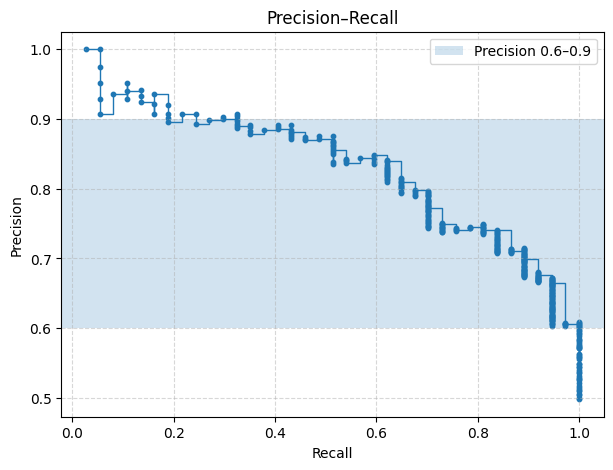

    threshold  precision    recall
19   0.820412   0.895358  0.189189
22   0.817706   0.893410  0.243243
23   0.817316   0.898885  0.270270
25   0.812798   0.899637  0.297297
29   0.808691   0.896824  0.324324


In [57]:
band = plot_pr_from_threshold_table(best_tuned_model, h2o_valid, precision_band=(0.6, 0.9))